# Run wind farm simulation

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
# import and setup site and windTurbines
%load_ext py_wake.utils.notebook_extensions
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from py_wake.utils import layouts 
from py_wake.utils.profiling import timeit, profileit
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake import BastankhahGaussian
import xarray as xr
from py_wake.utils.plotting import setup_plot
xr.set_options(display_expand_data=False)

site = Hornsrev1Site()
x, y = site.initial_position.T
windTurbines = V80()

wf_model = BastankhahGaussian(site, windTurbines)

print(wf_model)

BastankhahGaussian(PropagateDownwind, BastankhahGaussianDeficit-wake, SquaredSum-superposition)


## All wind directions and wind speeds

Run the wind farm simulation by calling the wind farm model. As default, the model will be run for all wind directions and wind speeds defined in `site.default_wd` and `site.default_ws`(which defaults to [0,1,..,359] and [3,4,..,25])

The call will return a `SimulationResult`

In [3]:
# run wind farm simulation
sim_res = wf_model(x, y, # wind turbine positions
                   h=None, # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0, # Wind turbine types
                   wd=None, # Wind direction (defaults to site.default_wd (0,1,...,360 if not overriden))
                   ws=None, # Wind speed (defaults to site.default_ws (3,4,...,25m/s if not overriden))
                  )

## SimulationResult

A `SimulationResult` is a xarray dataset with some additional methods and attributes. 
It has the coordinates

- `wt`: Wind turbine number
- `wd`: Ambient reference wind direction
- `ws`: Ambient reference wind speed
- `x`,`y`,`h`: position and hub height of wind turbines

and data variables:

- `WD`: Local free-stream wind direction
- `WS`: Local free-stream wind speed
- `TI`: Local free-stream turbulence intensity
- `P`: Probability of flow case (wind direction and wind speed)
- `WS_eff`: Effetive local wind speed [m/s]
- `TI_eff`: Effective local turbulence intensity
- `power`: Effective power production [W]
- `ct`: Thrust coefficient
- `Yaw`: Yaw misalignment [deg]

where "effective" means "including wake effects"
 

In [4]:
sim_res

<xarray.SimulationResult>
Dimensions:           (wt: 80, wd: 360, ws: 23)
Coordinates:
  * wt                (wt) int32 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
  * wd                (wd) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * ws                (ws) int32 3 4 5 6 7 8 9 10 11 ... 18 19 20 21 22 23 24 25
    x                 (wt) float64 4.24e+05 4.24e+05 ... 4.294e+05 4.295e+05
    y                 (wt) float64 6.151e+06 6.151e+06 ... 6.148e+06 6.148e+06
    h                 (wt) float64 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0 70.0
    type              (wt) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables: (12/16)
    WS_eff            (wt, wd, ws) float64 3.0 4.0 5.0 6.0 ... 22.87 23.88 24.89
    TI_eff            (wt, wd, ws) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    Power             (wt, wd, ws) float64 0.0 6.66e+04 1.54e+05 ... 2e+06 2e+06
    CT                (wt, wd, ws) float64 0.0 0.818 0.806 ... 0.06084 0.05377
    wd_bin_size       int32 1
    WS                (ws) int32 3 4 5 6 7 8 9 10 11 ... 18 19 20 21 22 23 24 25
    ...                ...
    Weibull_A         (wd) float64 9.177 9.177 9.177 9.177 ... 9.177 9.177 9.177
    Weibull_k         (wd) float64 2.393 2.393 2.393 2.393 ... 2.393 2.393 2.393
    Sector_frequency  (wd) float64 0.001199 0.001199 ... 0.001199 0.001199
    P                 (wd, ws) float64 6.147e-05 8.559e-05 ... 2.193e-08
    tilt              int32 0
    yaw               int32 0

Data can be selected using the xarray `sel` method, e.g. the power production of wind turbine 3 when the wind is coming from the East (90deg) is 2.634MW:

In [5]:
sim_res.Power.sel(wt=3, wd=0)

<xarray.DataArray 'Power' (ws: 23)>
0.0 5.52e+04 1.309e+05 2.418e+05 3.947e+05 ... 2e+06 2e+06 2e+06 2e+06 2e+06
Coordinates:
    wt       int32 3
    wd       int32 0
  * ws       (ws) int32 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25
    x        float64 4.242e+05
    y        float64 6.15e+06
    h        float64 70.0
    type     int32 0
Attributes:
    Description:  Power [W]

Data can be plotted using the xarray `plot` method, e.g. the power production of wind turbine 0 as a function of wind direction

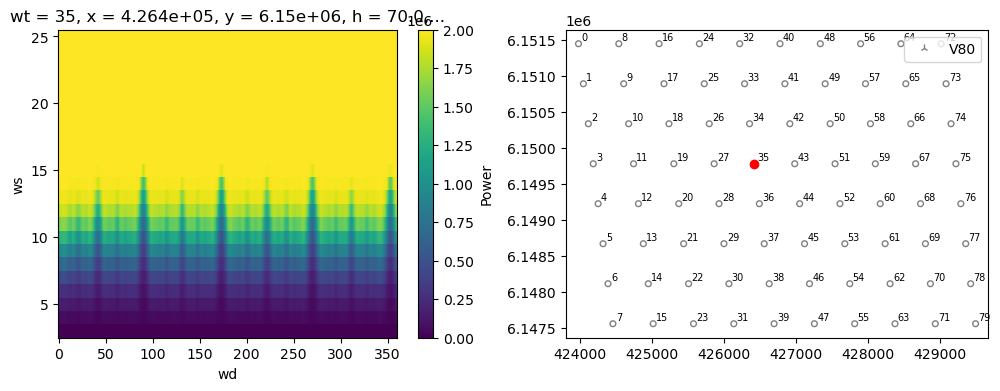

In [6]:
ax1, ax2 = plt.subplots(1,2, figsize=(12,4))[1]
sim_res.Power.sel(wt=35).T.plot(ax=ax1)
windTurbines.plot(x,y, ax=ax2)
ax2.plot(x[35],y[35],'or')

### AEP calculation

Furthermore, `SimulationResult`, contains a method, `aep` that calculates the Annual Energy Production

In [7]:
sim_res.aep()

<xarray.DataArray 'AEP [GWh]' (wt: 80, wd: 360, ws: 23)>
0.0 4.993e-05 0.0001429 0.0002968 ... 5.757e-06 2.478e-06 1.005e-06 3.842e-07
Coordinates:
  * wt       (wt) int32 0 1 2 3 4 5 6 7 8 9 10 ... 70 71 72 73 74 75 76 77 78 79
  * wd       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int32 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25
    x        (wt) float64 4.24e+05 4.24e+05 4.241e+05 ... 4.294e+05 4.295e+05
    y        (wt) float64 6.151e+06 6.151e+06 6.15e+06 ... 6.148e+06 6.148e+06
    h        (wt) float64 70.0 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0 70.0 70.0
    type     (wt) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    Description:  Annual energy production [GWh]

The total wind farm AEP is obtained using the `sum` method

In [8]:
sim_res.aep().sum()

<xarray.DataArray 'AEP [GWh]' ()>
682.0

The `aep` method take an optional input, `with_wake_loss` (default is True), which can be used to e.g. calculate the wake loss of the wind farm

In [9]:
aep_with_wake_loss = sim_res.aep().sum().data
aep_witout_wake_loss = sim_res.aep(with_wake_loss=False).sum().data
(aep_witout_wake_loss-aep_with_wake_loss) / aep_witout_wake_loss

0.08332281558952935

## Time series

Instead of simulating all wind speeds and wind directions, it is also possible to simulate time series of wind speed and wind directions.

This allows simulation of time-dependent inflow conditions, e.g. combinations of wd,ws,shear,ti,density,etc. and turbine operation, e.g. periods where one or more wind turbines are stopped due to failure or maintaince

Note, however, that PyWake considers the time series as discrete stationary conditions, i.e. a gust hits the whole wind farm at the same time

In [10]:
# load a time series of wd, ws and ti
from py_wake.examples.data import example_data_path
d = np.load(example_data_path + "/time_series.npz")
n_days=30
wd, ws, ws_std = [d[k][:6*24*n_days] for k in ['wd', 'ws', 'ws_std']]
ti = np.minimum(ws_std/ws,.5)
time_stamp = np.arange(len(wd))/6/24

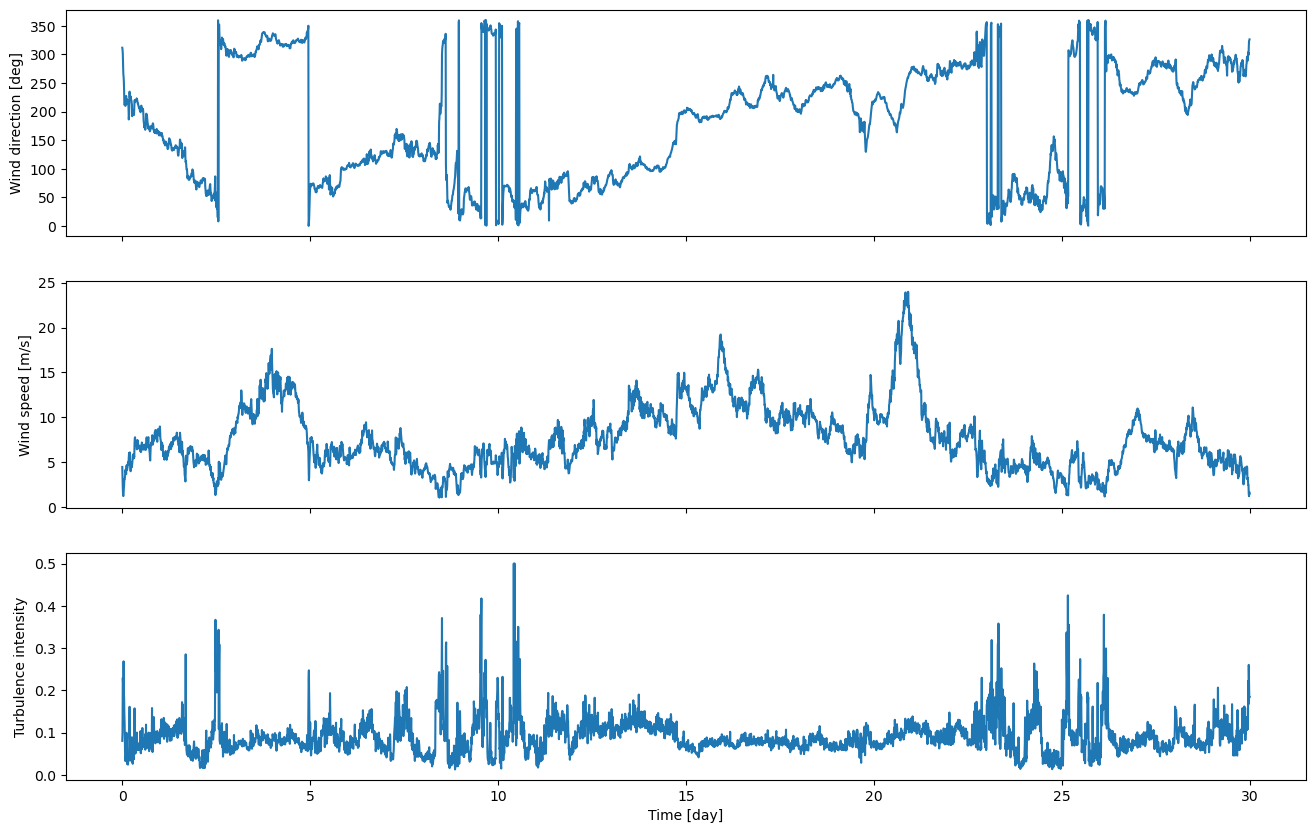

In [11]:
# plot time series
axes = plt.subplots(3,1, sharex=True, figsize=(16,10))[1]
for ax, (v,l) in zip(axes, [(wd, 'Wind direction [deg]'),(ws,'Wind speed [m/s]'),(ti,'Turbulence intensity')]):
    ax.plot(time_stamp, v)
    ax.set_ylabel(l)
_ = ax.set_xlabel('Time [day]')

**Time-dependent wind turbine operation**

Extend the wind turbine with a `operating` setting (0=stopped, 1=normal operation)

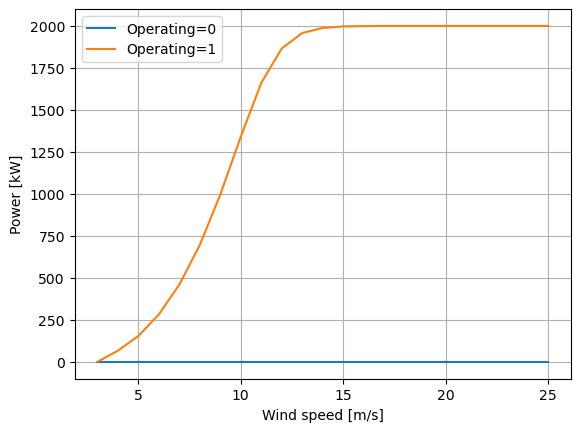

In [12]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunctionList, PowerCtTabular

# replace powerCtFunction
windTurbines.powerCtFunction = PowerCtFunctionList(
    key='operating',
    powerCtFunction_lst=[PowerCtTabular(ws=[0, 100], power=[0, 0], power_unit='w', ct=[0, 0]), # 0=No power and ct
                         V80().powerCtFunction], # 1=Normal operation
    default_value=1)

# plot power curves
u = np.arange(3,26)
for op in [0,1]:
    plt.plot(u, windTurbines.power(u, operating=op)/1000, label=f'Operating={op}')
setup_plot(xlabel='Wind speed [m/s]', ylabel='Power [kW]')

Make time-dependent operating variable

In [13]:
operating = np.ones((len(x), len(time_stamp))) # shape=(#wt, #time stamps)
operating[0,(time_stamp>15)&(time_stamp<20)] = 0 # wt0 not operating from day 5 to 15

Call the wind farm model with the `time=time_stamp` and the time-dependent `operating` key-word argument

In [14]:
# setup new WindFarmModel with site containing time-dependent TI and run simulation
wf_model = BastankhahGaussian(site, windTurbines)
sim_res_time = wf_model(x, y, # wind turbine positions
                        wd=wd, # Wind direction time series
                        ws=ws, # Wind speed time series
                        time=time_stamp, # time stamps
                        TI=ti, # turbulence intensity time series
                        operating=operating # time dependent operating variable
                  )

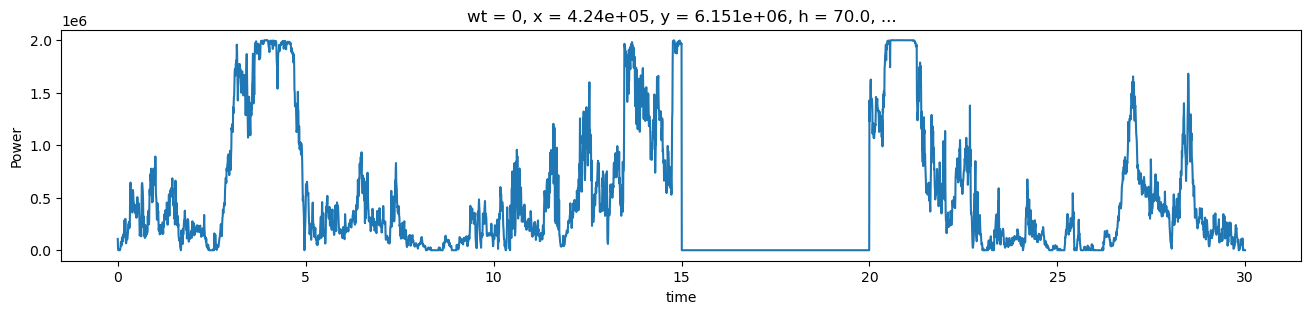

In [15]:
sim_res_time.Power.sel(wt=0).plot(figsize=(16,3))

In [16]:
sim_res_time.operating

<xarray.DataArray 'operating' (wt: 80, time: 4320)>
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Coordinates:
  * wt       (wt) int32 0 1 2 3 4 5 6 7 8 9 10 ... 70 71 72 73 74 75 76 77 78 79
    wd       (time) float64 311.5 308.1 301.7 280.2 ... 310.6 323.3 324.4 326.1
    ws       (time) float64 4.47 3.181 2.215 1.391 ... 1.473 1.214 1.692 1.493
    x        (wt) float64 4.24e+05 4.24e+05 4.241e+05 ... 4.294e+05 4.295e+05
    y        (wt) float64 6.151e+06 6.151e+06 6.15e+06 ... 6.148e+06 6.148e+06
    h        (wt) float64 70.0 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0 70.0 70.0
    type     (wt) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
  * time     (time) float64 0.0 0.006944 0.01389 0.02083 ... 29.98 29.99 29.99

In the no-operating periode time=5..15, the power is 0 as it should be

## Chunkification and parallelization

PyWake makes it easy to split the wind farm simulation computation into smaller subproblems. This allows:

- Simulation of large wind farms or time series with less memory usage
- Parallel execution for faster simulation

### Chunkfication
To split the simulation into smaller subtasks, just specify the desired number of `wd_chunks` and `ws_chunks`.

In [17]:
# split problem into 4x2 subtasks and simulate sequentially on one CPU
sim_res = wf_model(x, y,
                   wd_chunks=4,
                   ws_chunks=2)

Time series of (wd,ws)-flow cases is split into chunks, by specifying either `ws_chunks` or `wd_chunks`

In [18]:
sim_res_time = wf_model(x, y, # wind turbine positions
                        wd=wd, # Wind direction time series
                        ws=ws, # Wind speed time series
                        time=time_stamp, # time stamps
                        wd_chunks=4,
                  )

#### Wind speed or wind direction chunks

In [19]:
%%skip
n_lst = [1,2,4,8,16,23,32]
res = {'ws_chunks': np.array([(n,) + profileit(wf_model)(x, y, wd_chunks=1, ws_chunks=n)[1:] for n in tqdm(n_lst)]),
       'wd_chunks': np.array([(n,) + profileit(wf_model)(x, y, wd_chunks=n, ws_chunks=1)[1:] for n in tqdm(n_lst)])}

ax1,ax2 = plt.subplots(1,2,figsize=(12,4))[1]

for k, d in res.items():
    n,t,m = d.T
    ax1.plot(n,t, label=k)
    ax2.plot(n,m, label=k)
setup_plot(ax=ax1, ylabel='Time [s]', xlabel='Number of chunks')
setup_plot(ax=ax2, ylabel='Memory usage [MB]', xlabel='chunks')
plt.savefig('RunWindFarmSimuation_wdws_chunks.svg')

Cell skipped. Precomputed result shown below. Remove '%%skip' to force run. 


Result computed on the Sophia HPC cluster. Note that the number of wind speed chunks is limited to the number of wind speeds, in this case 23.


It is clearly seen that chunkification of wind directions are more efficient than chunkification of wind speeds with respect to both time and memory usage.

It is also seen that chunkification reduces the memory usage at the cost of computation time. With 32 wind direction chunks, the computational time is more than doubled, i.e. the speedup from running in parallel on a system with 32 CPUs is expected to be less than 16 times.

### Parallelization
Running a wind farm simulation in parallel is just as easy - simply specify the number of CPUs to use to the input argument `n_cpu` or `None` to use all available CPUs.

As seen above, wind directions chunks are more efficient. Hence, the problem is as default split into `n_cpu` wind direction chunks, where `n_cpu` is the numbers of CPUs to use. 

As default, `n_cpu=1` (sequential execution), so to run in parallel, you need to specify a number of CPUs, e.g. `n_cpu=4`. Alternatively, `n_cpu=None` will use all available CPUs.

In [20]:
sim_res = wf_model(x, y,
                   n_cpu=None # run wind directions in parallel on all available CPUs
                  )

##### CPU utilization
The plot below shows the time used to calculate the AEP on 1-32 CPUs as a function of number of wind turbines.

In [21]:
%%skip
from py_wake.utils import layouts 
from py_wake.utils.profiling import timeit
from tqdm.notebook import tqdm

n_lst = np.arange(100,600,100)

def run(n, n_cpu):
    x,y = layouts.rectangle(n,20,5*windTurbines.diameter())
    return (n, n_cpu, np.mean(timeit(wf_model, min_runs=5)(x,y,n_cpu=n_cpu)[1]))

res = {f'{n_cpu} CPUs': np.array([run(n, n_cpu=n_cpu) for n in tqdm(n_lst)]) for n_cpu in [1, 4, 16, 32]}

ax1,ax2 = plt.subplots(1,2, figsize=(12,4))[1]
for k,v in res.items():
    n,n_cpu,t = v.T
    ax1.plot(n, t, label=k)
    ax2.plot(n, res['1 CPUs'][:,2]/n_cpu/t*100, label=k)
setup_plot(ax=ax1,xlabel='No. wind turbines',ylabel='Time [s]')
setup_plot(ax=ax2,xlabel='No. wind turbines',ylabel='CPU utilization [%]')
plt.savefig('images/RunWindFarmSimulation_time_cpuwt.svg')

Cell skipped. Precomputed result shown below. Remove '%%skip' to force run. 


Result precomputed on the Sophia HPC cluster on a node with 32 CPUs.



The plot clearly shows that the time reduces with more CPUs. In this case, however, the gain from 16 to 32 CPUs is very limited. Note, this may highly dependend on the system architecture.

## Flow map

Finally, `SimulationResult` has a `flow_map` method which returns a `FlowMap` object

In [22]:
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake import BastankhahGaussian

site = IEA37Site(16)
x, y = site.initial_position.T
windTurbines = IEA37_WindTurbines()

wf_model = BastankhahGaussian(site, windTurbines)
sim_res = wf_model(x,y)

In [23]:
flow_map = sim_res.flow_map(grid=None, # defaults to HorizontalGrid(resolution=500, extend=0.2), see below
                            wd=270, 
                            ws=[9.8])

### plot_wake_map

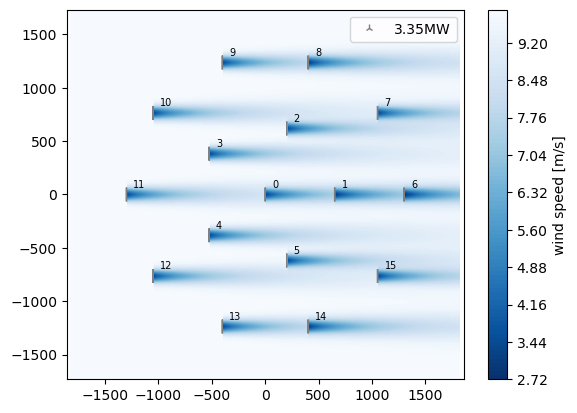

In [24]:
flow_map.plot_wake_map()

(-1820.0, 1820.0, -1730.9229, 1730.9229)

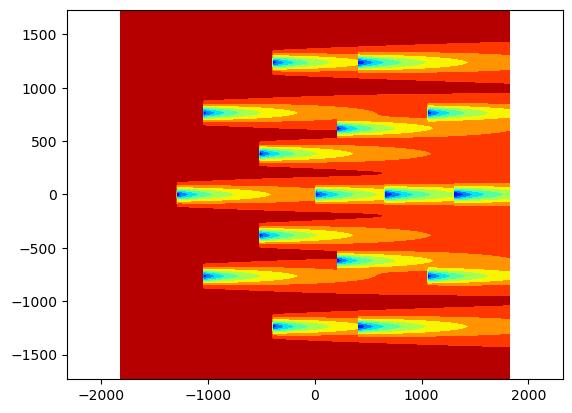

In [25]:
flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
                       cmap='jet', # color map
                       plot_colorbar=False, 
                       plot_windturbines=False, 
                       ax=None)
plt.axis('equal')

#### Grid

The grid argument should be either 

- a `HorizontalGrid`(same as `XYGrid`), `YZGrid` or 
- a tuple(X, Y, x, y, h) where X, Y is the meshgrid for visualizing the data and x, y, h are the flattened grid points

 
##### HorizontalGrid (XYGrid)


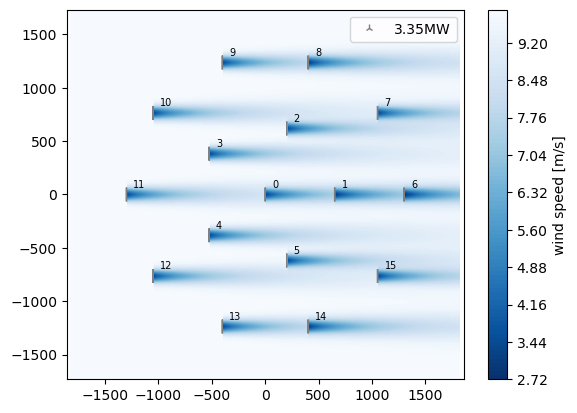

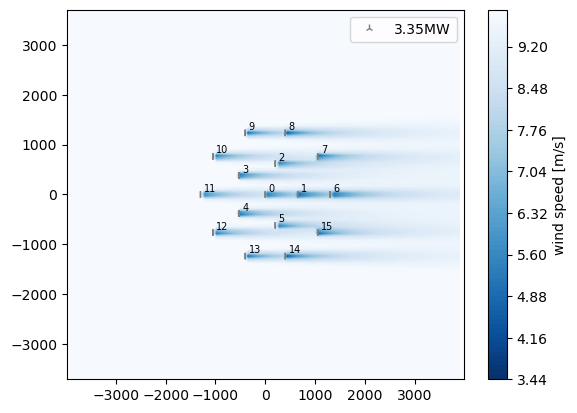

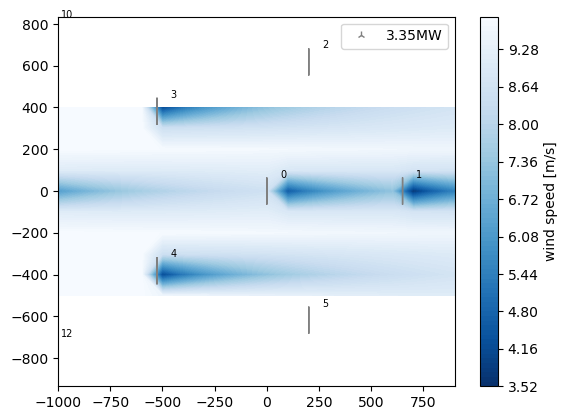

In [26]:
from py_wake import HorizontalGrid
for grid in [None, # defaults to HorizontalGrid(resolution=500, extend=0.2)
             HorizontalGrid(x=None, y=None, resolution=100, extend=1), # custom resolution and extend
             HorizontalGrid(x = np.arange(-1000,1000,100),
                            y = np.arange(-500,500,100)) # custom x and y
            ]:
    plt.figure()
    sim_res.flow_map(grid=grid, wd=270, ws=[9.8]).plot_wake_map()

##### YZGrid
Plotting the flow map in the vertical YZ plane through the red dashed line 
![image3.png](images/RunWindFarmSimulation_yzgrid.png)


can be done using the `YZGrid`

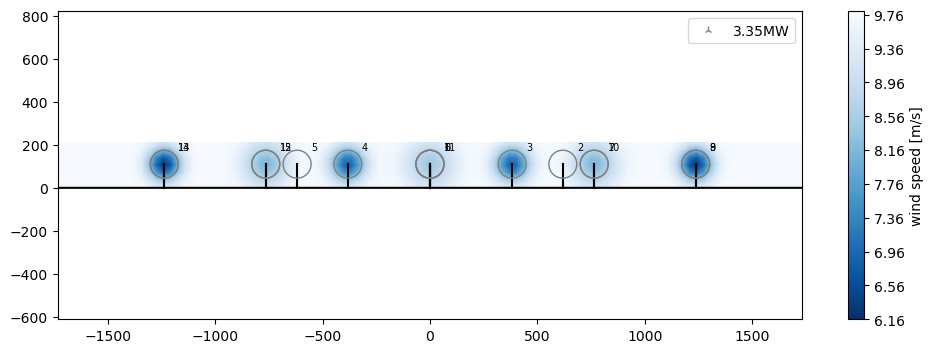

In [27]:
from py_wake import YZGrid
plt.figure(figsize=(12,4))
sim_res.flow_map(YZGrid(x=-100, y=None, resolution=100), wd=270, ws=None).plot_wake_map()

##### XZGrid
Plotting the flow map in the vertical XZ plane through the red dashed line
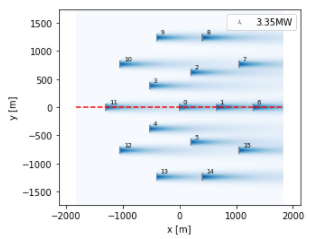
 can be done using the `XZGrid`

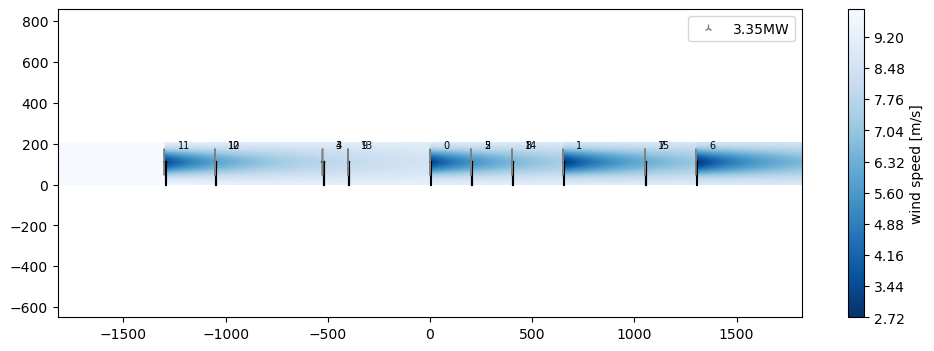

In [28]:
from py_wake import XZGrid
plt.figure(figsize=(12,4))
sim_res.flow_map(grid=XZGrid(y=0, resolution=1000), wd=270, ws=None).plot_wake_map()